# Processing conduit model sweeps
 - Outcome codes --> explosive/effusive/intrusive transitions
 - Decompression Rates, Bubble Number Densities, Porosities associated with different nucleation events
 - 

## Imports and User input

In [1]:
from os.path import join

import numpy as np
import pandas as pd
from itertools import product, compress
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

# import matplotlib.contour as mcon
# import matplotlib.colormaps as mpc

from labellines import labelLines

import myojin_python.mat_tools as mat
import myojin_python.process_conduit_outcomes as po
from myojin_python.config import DATA_DIR, FIGURES_DIR

In [2]:
# PARAMETER INPUT

dataDir   = DATA_DIR / 'refinedSweep/'
codesFile = 'outcomeCodeSummary.mat'

# % Test file
# % foi = '2024-04-26_myojin_Q8_Z0900_Zw500_357n_dP_21_n0_excess_17.mat';
foi = 'myojin_Q8_Z0900_Zw500';

max_P = 2e7 # Max overpressure
sigma = 2.0 # Gaussian filter size (pix)

# --> Sweep sets for which to make regime plots
logQ = [8., 9.]
Ztot = [1400.,2200.,6000.]

# Plot boundary contours only for explosive and intrusive PLOT codes
# keep_outcomes = ['invalidIntrusive','validFragPressBalance','validExplosive']
# outcome_cmaps = ['Oranges','Blues','Purples']
# keep_outcomes = ['invalidIntrusive','validExplosive']
keep_outcomes = ['invalidIntrusive','validFragPressBalance']
outcome_cmaps = ['Oranges','Blues']
# keep_codes = {
#     'intrusive': 0.,
#     'press_bal': 2.,
#     'explosive': 3.} 


# Pressure scale multiplier for plotting
Pscale = 1e-6

print_figs = True
## ------------------------------------------------------------------------##

In [3]:

# --------  PULL DATA --------
matfile = join(dataDir,codesFile)

all_outcome_codes = mat.matfile_struct_to_dict(matfile, 'allOutcomeCodes')
simple_plot_codes = mat.matfile_struct_to_dict(matfile, 'simplePlotIndex')

n0 = all_outcome_codes['n0_excess']
P = all_outcome_codes['dP']

# --> Pull test codes
outcome_codes = all_outcome_codes[foi]
plot_codes = simple_plot_codes[foi]

## Parse names and contours into a dataframe

In [4]:

# ------- PARSE SWEEP NAMES --------
#  - into a dataframe for processing/plotting control
sweep_names = [key for key in all_outcome_codes.keys() if 'myojin' in key]

# Initialize
sweeps = {'logQ': np.zeros(len(sweep_names)),
              'Z0'  : np.zeros(len(sweep_names)),
              'Zw'  : np.zeros(len(sweep_names)),
             }

for ii,foi in enumerate(sweep_names):
    chunks = foi.split('_')
    for chunk in chunks:
        if 'Q' in chunk:
            sweeps['logQ'][ii] = float(chunk.strip('Q'))
        elif 'Z0' in chunk:
            sweeps['Z0'][ii] = float(chunk.replace('Z0',''))
        elif 'Zw' in chunk:
            sweeps['Zw'][ii] = float(chunk.strip('Zw'))

sweeps['Ztot'] = sweeps['Zw'] + sweeps['Z0']
sweeps['name'] = sweep_names

sweeps = pd.DataFrame(data = sweeps).sort_values(['logQ','Ztot','Zw'],ignore_index=True)
# print(sweeps)

# -------- Produce regime contours for each sweep into the dataframe  -----------

# Get simplified outcome code table
ctable = po.get_outcome_code_table(display=False)
keep_codes = ctable.loc[keep_outcomes]['SimplifiedCode']


# Run list
# all_contours = {name: [] for name in keep_outcomes}
empty_sweeps = {name: None for name in sweeps['name']}
all_contours_dict = {name: empty_sweeps.copy() for name in keep_outcomes}
code_set = []
for sweep in sweeps['name']:
    outcome_codes, plot_codes, P = po.process_outcome_codes(
        all_outcome_codes[sweep], 
        simple_plot_codes[sweep], 
        all_outcome_codes['dP'], 
        max_P=max_P)

    sweep_contours, contours_xy, unique_codes = po.get_label_contours(
        plot_codes, all_outcome_codes['n0_excess'],
        P,
        sigma=sigma)

    # if sweep=='myojin_Q9_Z05500_Zw500':
    #     print(sweep_contours)
    #     faafo
    #     print('wait!')
    # Filter for kept contour codes
    # sweep_contours = {name: contour for name,contour in sweep_contours.items() if int(name) in keep_codes.values}

    
    # Get all unique plot codes (post-cleaning for contour plots)
    code_set += list(unique_codes)
    for name,code in zip(keep_outcomes,keep_codes):
        if str(int(code)) in sweep_contours.keys():
            all_contours_dict[name][sweep] = sweep_contours[str(int(code))]
        # else:
        #     all_contours_dict[name][sweep] = None
    
    # for name,code in zip(keep_outcomes,keep_codes):
    #     cont = list(compress(contours_xy,np.isin(unique_codes,code)))
    #     if cont: # Simplify if result was not empty
    #         if sweep=='myojin_Q9_Z01100_Zw300':
    #             print(len(cont))
    #         cont = cont[0]
    #     else:
    #         cont = None
    #     contours[name].append(cont)

# sweeps = sweeps.join(pd.DataFrame(all_contours_dict))
sweeps = sweeps.merge(pd.DataFrame(all_contours_dict),left_on='name',right_index=True)
code_set = set(code_set)

print(code_set)

{np.float64(0.0), np.float64(1.0), np.float64(2.0)}


## QC plots for each sweep

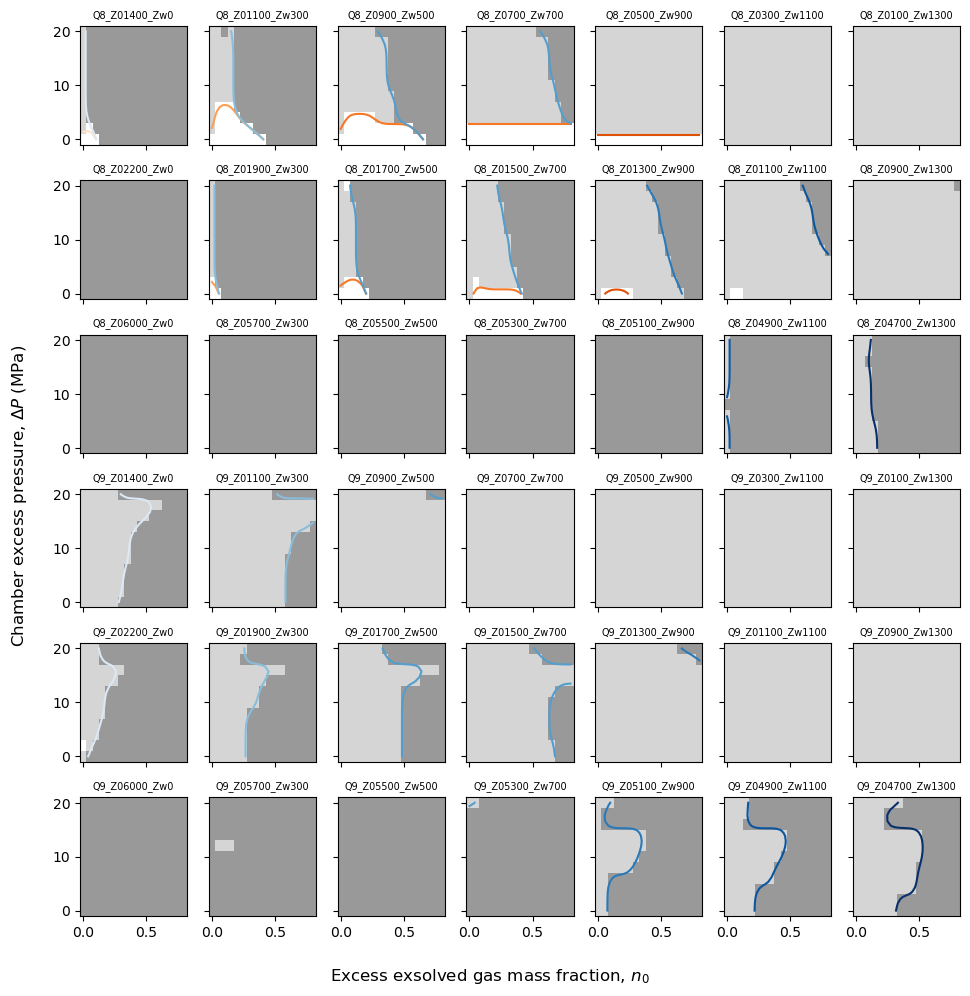

In [10]:
# QC plots for each sweep - just to ensure boundaries are well captured
figname = 'RegimeQC_all_sweeps.pdf'

fs = 7
grid_spec = {'hspace' : 0.3,
            'bottom' : 0.08,
            'left' : 0.09,
            'right' : 0.97,
            'top' : 0.97}

levels = sorted(np.array(list(set(sweeps['Zw']))))
nc = len(levels)
nr = int(sweeps.shape[0]/nc)

# Build colormaps for each contour regime of interest
dl = np.diff(levels)[0]
cmaps={}
norms={}
for name,cmap in zip(keep_outcomes,outcome_cmaps):
    cmaps[cmap] = plt.get_cmap(cmap, lut=nc+1)
    norms[cmap] = plt.Normalize(vmin=min(levels)-dl-0.5, vmax=max(levels)+0.5)


fig,axes = plt.subplots(nr,nc,figsize=[10, 10],sharex=True,sharey=True, gridspec_kw=grid_spec )
mesh_cmap = plt.get_cmap('Greys',lut=len(code_set))
for ii,(ax,sweep,Zw) in enumerate(zip(axes.flatten(),sweeps['name'],sweeps['Zw'])):
    _, plot_codes, P = po.process_outcome_codes(
    all_outcome_codes[sweep], 
    simple_plot_codes[sweep], 
    all_outcome_codes['dP'], 
    max_P=max_P)
    
    code_img = simple_plot_codes[sweep]
    CS = ax.pcolormesh(n0,P*Pscale,plot_codes, shading='auto',cmap=mesh_cmap,vmin=min(code_set),vmax=max(code_set),alpha=0.4)
    # plt.colorbar(CS)
    ax.set_title(sweep.replace('myojin_',''),fontsize=fs)
    
    for name,code,cmap,norm in zip(keep_outcomes,keep_codes,cmaps,norms):
        contours = all_contours_dict[name][sweep]
        # contour = sweeps.loc[sweeps['name']==sweep,name]
        if contours is not None:
            for contour in contours:
                # contour = contour.to_numpy()[0]
                color = cmaps[cmap](norms[norm](Zw))
                # print('wtaf',sweep)
                ax.plot(contour[:,0], contour[:,1]*Pscale, color=color)
        # else:
        #     print('wtaf')


    # code_img = all_outcome_codes[sweep]
# CS = plt.pcolormesh(n0,P*Pscale,plot_codes, shading='auto', edgecolor = 'k', linewidth=0.1,cmap=mesh_cmap)

fig.supxlabel('Excess exsolved gas mass fraction, $n_0$')
fig.supylabel('Chamber excess pressure, $\Delta P$ (MPa)')

if print_figs:
    plt.savefig(FIGURES_DIR / figname, format='pdf')

## Explosive transition contours plot

/Users/crrowell/miniconda3/envs/myojin_knoll/lib/python3.11/site-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=0.020049216822314447, xval=0.026). Clipping it into the allowed range.
  warnings.warn(
/Users/crrowell/miniconda3/envs/myojin_knoll/lib/python3.11/site-packages/labellines/core.py:216: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=0.02005392818301696, xval=0.026). Clipping it into the allowed range.
  warnings.warn(


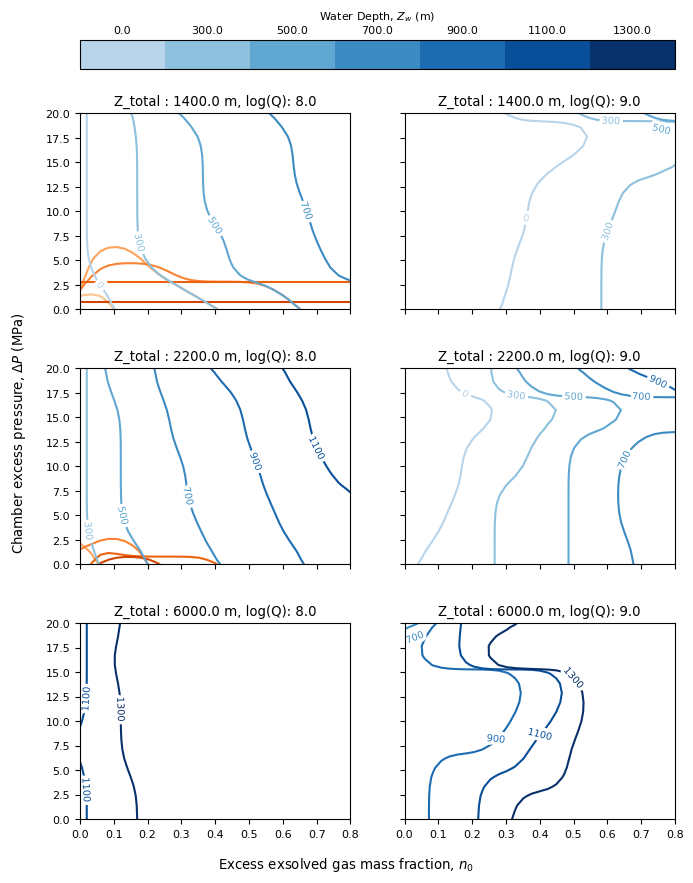

In [16]:
# Make a contour plot for each sweep set
def truncate_colormap(cmap: colors.LinearSegmentedColormap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)), N = n)
    return new_cmap

# FIGURE NAME
figname = 'RegimeContours.pdf'


#  -> 4-6 plots total, depending on our choices of Ztot
grid_spec = {'hspace' : 0.3,
            'bottom' : 0.07,
            'left' : 0.12,
            'right' : 0.97,
            'top' : 1.05,
            }
label_code = 2 # Add contour-like labels for explosive transition lines
fs = 8 # Main fontsize
label_fontsize = 7 # For contour labels

plt.rcParams.update({'font.size': fs})

# Manual positioning for line labels
x_vals = {f'{q:.0f}_{zt:.0f}': None for q,zt in product(logQ,Ztot)}
y_offsets = {f'{q:.0f}_{zt:.0f}': 0.0 for q,zt in product(logQ,Ztot)}
x_vals['8_1400'] = (0.06,0.176,0.4,0.67)
x_vals['9_1400'] = (0.36,0.6,0.61,0.76)
y_offsets['9_1400'] = (-10.,0.0,0.0,-1.)
x_vals['8_2200'] = (0.025,0.127,0.32,0.52,0.7)
x_vals['9_2200'] = (0.18,0.33,0.5,0.65,0.7,0.75)
x_vals['8_6000'] = (0.026,0.026,0.12)
x_vals['9_6000'] = (0.03,0.27,0.4,0.5)
y_offsets['9_6000'] = (-1.3,-7,-6.5,0,0)
# y_offsets['9_1400'] = (-10.,0.0,0.0,-1.)

# Get levels and colormaps for the regime boundary lines
levels = sorted(np.array(list(set(sweeps['Zw']))))
nl = len(levels)
dl = np.diff(levels)[0]
cmaps={}
norms={}
extra_cols = 2
for name,cmap in zip(keep_outcomes,outcome_cmaps):
    # cmaps[cmap] = plt.get_cmap(cmap, lut=len(levels)+extra_cols)
    # norms[cmap] = plt.Normalize(vmin=min(levels)-extra_cols*dl, vmax=max(levels))
    cmaps[cmap] = truncate_colormap(plt.get_cmap(cmap), minval=0.3, n=nl)
    norms[cmap] = plt.Normalize(vmin=min(levels), vmax=max(levels))

nr = len(Ztot)
nc = len(logQ)

fig,axes = plt.subplots(nr,nc,figsize=[7, 9],sharex=True,
                        sharey=True,
                       gridspec_kw=grid_spec)

# Iterate over different combinations of logQ, Ztotal to produce the various plots
for ax,(q,zt) in zip(axes.transpose().flatten(), product(logQ,Ztot)):
    label_lines = []
    this_set = sweeps[(sweeps['Ztot']==zt) & (sweeps['logQ']==q)]

    for name,code,cmap,norm in zip(keep_outcomes,keep_codes,cmaps,norms):
        for Zw,sweep in zip(levels,this_set['name']):
            
            contours = all_contours_dict[name][sweep]
        # contour = sweeps.loc[sweeps['name']==sweep,name]
            if contours is not None:
                for contour in contours:
                    # contour = contour.to_numpy()[0]
                    color = cmaps[cmap](norms[norm](Zw))
                    # print('wtaf',sweep)
                    this_line = ax.plot(contour[:,0], contour[:,1]*Pscale, color=color, label=f'{Zw:.0f}')
                    if code==label_code:
                        label_lines += this_line
    ax.set_xlim(left=min(n0), right = np.max(n0))
    ax.set_ylim(min(P)*Pscale,max(P)*Pscale)
    ax.set_title(f'Z_total : {zt} m, log(Q): {q}')
    # if x_vals[f'{q:.0f}_{zt:.0f}'] is not None:
    labelLines(label_lines, 
               xvals=x_vals[f'{q:.0f}_{zt:.0f}'], 
               yoffsets = y_offsets[f'{q:.0f}_{zt:.0f}'], 
               fontsize=label_fontsize)
    # else:
    #     labelLines(label_lines, fontsize=label_fontsize)

#--- Build color bar for contours ----
# Which axis?
test_levels = np.concat(([-150],levels + np.diff(levels,prepend=-300)/2))
boundary_levels = np.arange(0.,1.0,nl+1)
tick_locs = np.linspace(0.5/nl,1.0-0.5/nl,nl)
cmap = cmaps['Blues']
# norm = mpl.colors.BoundaryNorm(boundary_levels, cmap.N-extra_cols)
cbar = fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap),
            # mpl.cm.ScalarMappable(norm=norms['Blues'], cmap=cmap),
            # ticks=levels,
            orientation='horizontal',
            ax=axes,
            label="Water Depth, $Z_w$ (m)",
            location='top')
cbar.set_ticks(ticks=tick_locs, labels = levels)
cbar.ax.tick_params(size=0)

fig.supxlabel('Excess exsolved gas mass fraction, $n_0$')
fig.supylabel('Chamber excess pressure, $\Delta P$ (MPa)')

if print_figs:
    plt.savefig(FIGURES_DIR / figname, format='pdf')